This script looks at the actual sweeping data to determine what differs the two excitatory neuron groups from the firing rate-cell size plot (aka spiny and weird_spiny). Codes modified from celltypes.ipynb.

In [1]:
from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.ephys.ephys_extractor import EphysSweepFeatureExtractor

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from mpl_toolkits.mplot3d import Axes3D

In [30]:
from matplotlib import rcParams
rcParams['figure.dpi']=600

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 50)

# %matplotlib inline
# %matplotlib qt
%matplotlib widget



In [4]:
sns.set(style = "darkgrid")

In [5]:
id_df = pd.read_csv('../result/sub_dendrite_type.tsv',sep='\t',index_col=0)

In [6]:
id_df

,Species,ef__threshold_i_long_square,ef__avg_firing_rate,tag__dendrite_type,sub_dendrite_type
313862167,Mouse,130.0,32.510986,aspiny,aspiny
321708130,Mouse,370.0,89.644985,aspiny,aspiny
323452196,Mouse,270.0,79.550438,aspiny,aspiny
323475862,Mouse,70.0,6.212917,aspiny,aspiny
324266189,Mouse,70.0,21.064418,sparsely spiny,sparsely spiny
...,...,...,...,...,...
623185845,Mouse,70.0,16.528926,sparsely spiny,sparsely spiny
637038252,Human,10.0,30.587276,aspiny,aspiny
643572206,Human,20.0,55.594449,aspiny,aspiny
643575207,Human,250.0,112.107623,aspiny,aspiny


In [7]:
# If you don't have the sweep data downoaded yet, this paragraph will download them first. 
# If a time-out error occured, just rerun the block. You might need multiple times to download everything. 

ctc = CellTypesCache(manifest_file='../data/cell_types/manifest.json')

sweeps_df=pd.DataFrame(columns=['specimen_id',
                                'dendrite_type',
                                'cell_firing_rate',
                                'threshold_i_long_square',
                                'sweep_number',
                                'sweep_FR',
                                'stimulus_absolute_amplitude'])

for specimen_id in id_df.index:
    dendrite_type=id_df.loc[specimen_id]['sub_dendrite_type']
    cell_firing_rate=id_df.loc[specimen_id]['ef__avg_firing_rate']
    threshold_i_long_square=id_df.loc[specimen_id]['ef__threshold_i_long_square']
    data_set = ctc.get_ephys_data(specimen_id)
    ephys_sweep_info = ctc.get_ephys_sweeps(specimen_id=specimen_id)
    for swp_info in ephys_sweep_info:
        if ((swp_info['stimulus_name']=='Long Square') and (swp_info['num_spikes']!='None')):
            sweep_number=swp_info['sweep_number']
            num_spikes=swp_info['num_spikes']
            stimulus_duration=swp_info['stimulus_duration']
            try:
                sweep_FR=num_spikes/stimulus_duration
            except:
                sweep_FR=np.nan
            stimulus_relative_amplitude = swp_info['stimulus_relative_amplitude']
            stimulus_absolute_amplitude = swp_info['stimulus_absolute_amplitude']
            sweeps_df = sweeps_df.append({'specimen_id':specimen_id,
                                         'dendrite_type':dendrite_type,
                                         'cell_firing_rate':cell_firing_rate,
                                         'threshold_i_long_square':threshold_i_long_square,
                                         'sweep_number':sweep_number,
                                         'sweep_FR':sweep_FR,
                                         'stimulus_absolute_amplitude':stimulus_absolute_amplitude
                                         },ignore_index=True)
sweeps_df

,specimen_id,dendrite_type,cell_firing_rate,threshold_i_long_square,sweep_number,sweep_FR,stimulus_absolute_amplitude
0,313862167,aspiny,32.510986,130.0,22,NaN,-110.000002
1,313862167,aspiny,32.510986,130.0,23,NaN,-90.000001
2,313862167,aspiny,32.510986,130.0,24,NaN,-69.999999
3,313862167,aspiny,32.510986,130.0,25,NaN,-50.000001
4,313862167,aspiny,32.510986,130.0,26,NaN,-29.999999
...,...,...,...,...,...,...,...
9107,643582610,aspiny,163.398693,80.0,47,2.00004,119.999996
9108,643582610,aspiny,163.398693,80.0,48,13.00026,159.999999
9109,643582610,aspiny,163.398693,80.0,49,18.00036,159.999999
9110,643582610,aspiny,163.398693,80.0,50,18.00036,159.999999


In [8]:
# Import cell volumes
volume_df = pd.read_csv('../result/volume_FR_nomenclature_capacitance.tsv',sep='\t',index_col=0,usecols=['Unnamed: 0','nm_volume'])

In [9]:
sweeps_df = pd.merge(left=sweeps_df,right=volume_df,left_on='specimen_id',right_index=True)

In [10]:
FR_sweeps_df = sweeps_df[~np.isnan(sweeps_df['sweep_FR'])] # sweeps with firing rates

In [35]:
FR_sweeps_df.to_csv('../result/sweep_FR-nm_volume.tsv',sep='\t')

In [17]:
set(FR_sweeps_df['dendrite_type'])

{'aspiny', 'sparsely spiny', 'spiny', 'weird_spiny'}

In [19]:
FR_sweeps_df['dendrite_type'].iloc[0]

'aspiny'

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for specimen_id in set(FR_sweeps_df['specimen_id']):
    df = FR_sweeps_df[FR_sweeps_df['specimen_id']==specimen_id]
    df = df.sort_values(by=['stimulus_absolute_amplitude'])
    
    if df['dendrite_type'].iloc[0]=='spiny':
        color='blue'
    elif df['dendrite_type'].iloc[0]=='weird_spiny':
        color='orange'
    elif df['dendrite_type'].iloc[0]=='aspiny':
        color='green'
    elif df['dendrite_type'].iloc[0]=='sparsely spiny':
        color='red'

    x = df['stimulus_absolute_amplitude']
    y = df['nm_volume']
    z = df['sweep_FR']
    
    

    ax.scatter(x, y, z,s=1,c=color,alpha=0.2)
    ax.plot(x,y,z,c=color,alpha=0.2)


ax.set_xlabel('Stimulus Amplitude')
ax.set_ylabel('Cell Volume')
ax.set_zlabel('Sweep Firing Rate')

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'Stimulus Amplitude')

Text(0.5, 0, 'Cell Volume')

Text(0.5, 0, 'Sweep Firing Rate')

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for specimen_id in set(FR_sweeps_df['specimen_id']):
    df = FR_sweeps_df[FR_sweeps_df['specimen_id']==specimen_id]
    df = df.sort_values(by=['stimulus_absolute_amplitude'])
    
    x = df['stimulus_absolute_amplitude']
    y = df['nm_volume']
    z = df['sweep_FR']
    
    if df['dendrite_type'].iloc[0]=='spiny':
        color='blue'
        ax.scatter(x, y, z,s=1,c=color,alpha=0.5)
        ax.plot(x,y,z,c=color,alpha=0.5)
    elif df['dendrite_type'].iloc[0]=='weird_spiny':
        color='orange'
        ax.scatter(x, y, z,s=1,c=color,alpha=0.2)
        ax.plot(x,y,z,c=color,alpha=0.2)
    else:
        pass

ax.set_xlabel('Stimulus Amplitude')
ax.set_ylabel('Cell Volume')
ax.set_zlabel('Sweep Firing Rate')

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'Stimulus Amplitude')

Text(0.5, 0, 'Cell Volume')

Text(0.5, 0, 'Sweep Firing Rate')

In [ ]:
# Working on this right now. Get a figure for each cell? 
# FR-stimuli relationship, shows cell size and dendrite type in file name?
for specimen_id in set(FR_sweeps_df['specimen_id']):
    df = FR_sweeps_df[FR_sweeps_df['specimen_id']==specimen_id]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    x = df['stimulus_absolute_amplitude']
    y = df['nm_volume']
    z = df['sweep_FR']
    
    if df['dendrite_type'].iloc[0]=='spiny':
        color='blue'
        ax.scatter(x, y, z,s=1,c=color,alpha=0.5)
        ax.plot(x,y,z,c=color,alpha=0.5)
    elif df['dendrite_type'].iloc[0]=='weird_spiny':
        color='orange'
        ax.scatter(x, y, z,s=1,c=color,alpha=0.5)
        ax.plot(x,y,z,c=color,alpha=0.5)
    else:
        pass

ax.set_xlabel('Stimulus Amplitude')
ax.set_ylabel('Cell Volume')
ax.set_zlabel('Sweep Firing Rate')

plt.show()

In [72]:
sweeps_df[sweeps_df['dendrite_type']=='weird_spiny']

,specimen_id,dendrite_type,cell_firing_rate,sweep_number,sweep_FR,stimulus_absolute_amplitude
1340,508279351,weird_spiny,115.606936,45,NaN,-110.000002
1341,508279351,weird_spiny,115.606936,46,NaN,-90.000001
1342,508279351,weird_spiny,115.606936,47,NaN,-69.999999
1343,508279351,weird_spiny,115.606936,48,NaN,-50.000001
1344,508279351,weird_spiny,115.606936,49,NaN,-29.999999
...,...,...,...,...,...,...
2739,531520401,weird_spiny,146.198830,63,10.00020,330.000000
2740,531520401,weird_spiny,146.198830,64,2.00004,190.000002
2741,531520401,weird_spiny,146.198830,65,2.00004,190.000002
2742,531520401,weird_spiny,146.198830,66,2.00004,190.000002


In [73]:
exp_sweep_df = sweeps_df[sweeps_df['specimen_id']==508279351]

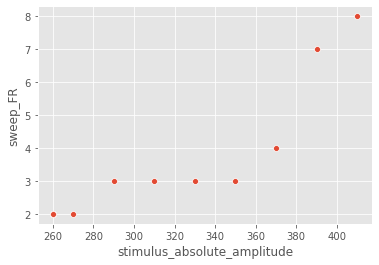

In [74]:
sns.scatterplot(data=exp_sweep_df, x="stimulus_absolute_amplitude", y="sweep_FR")

In [46]:
num_list=[]
amp_list=[]
abs_amp_list=[]
dur_list=[]
for swp_info in ephys_sweep_info:
    if ((swp_info['stimulus_name']=='Long Square') and (swp_info['num_spikes']!='None')):
        num_list.append(swp_info['num_spikes'])
        amp_list.append(swp_info['stimulus_relative_amplitude'])
        abs_amp_list.append(swp_info['stimulus_absolute_amplitude'])
        dur_list.append(swp_info['stimulus_duration'])
set(num_list)
set(amp_list)
set(abs_amp_list)
set(dur_list)

{2, 3, 4, 7, 8, None}

{1.0, 2.40000009536743, 2.5, 2.59999990463257}

{-110.000002162547,
 -90.0000005077395,
 -69.9999988529321,
 -50.0000006675716,
 -29.9999990127642,
 -9.99999996004197,
 9.99999996004197,
 29.9999990127642,
 50.0000006675716,
 69.9999988529321,
 90.0000005077395,
 110.000002162547,
 129.99999687846,
 149.999998533268,
 170.000000188075,
 190.000001842883,
 210.00000349769,
 230.000005152498,
 239.999992102113,
 249.999992929517,
 259.999993756921,
 269.999994584325,
 289.999996239132,
 309.999997893939,
 329.999999548747,
 350.000001203554,
 370.000002858362,
 390.000004513169,
 410.000006167976}

{0.99998}

In [57]:
ephys_sweep_info[70]

{'bridge_balance_mohm': 8.97435855865479,
 'id': 508279596,
 'leak_pa': 41.3947525024414,
 'num_spikes': 7,
 'peak_deflection': None,
 'post_noise_rms_mv': 0.0301464349031448,
 'post_vm_mv': -80.032829284668,
 'pre_noise_rms_mv': 0.0382710993289948,
 'pre_vm_mv': -80.4413681030273,
 'slow_noise_rms_mv': 0.10019052028656,
 'slow_vm_mv': -80.4413681030273,
 'specimen_id': 508279351,
 'stimulus_absolute_amplitude': 390.000004513169,
 'stimulus_description': 'C1LSCOARSE150216[25]',
 'stimulus_duration': 0.99998,
 'stimulus_interval': None,
 'stimulus_name': 'Long Square',
 'stimulus_relative_amplitude': 1.0,
 'stimulus_start_time': 1.02,
 'stimulus_units': 'Amps',
 'sweep_number': 70,
 'vm_delta_mv': 0.408538818359375}

/opt/anaconda3/lib/python3.8/site-packages/allensdk/core/nwb_data_set.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  stimulus = stimulus_dataset.value
/opt/anaconda3/lib/python3.8/site-packages/allensdk/core/nwb_data_set.py:109: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  response = swp['response']['timeseries']['data'].value
/opt/anaconda3/lib/python3.8/site-packages/allensdk/core/nwb_data_set.py:125: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  swp_idx_start = swp['stimulus']['idx_start'].value
/opt/anaconda3/lib/python3.8/site-packages/allensdk/core/nwb_data_set.py:126: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  swp_length = swp['stimulus']['count'].value
/opt/anaconda3/lib/python3.8/site-packages/allensdk/core/nwb_data_set.py:135: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead

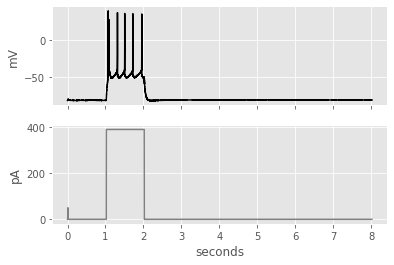

In [20]:


sweep_number = 70
sweep_data = data_set.get_sweep(sweep_number)

index_range = sweep_data["index_range"]
i = sweep_data["stimulus"][0:index_range[1]+1] # in A
v = sweep_data["response"][0:index_range[1]+1] # in V
i *= 1e12 # to pA
v *= 1e3 # to mV

sampling_rate = sweep_data["sampling_rate"] # in Hz
t = np.arange(0, len(v)) * (1.0 / sampling_rate)

plt.style.use('ggplot')
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(t, v, color='black')
axes[1].plot(t, i, color='gray')
axes[0].set_ylabel("mV")
axes[1].set_ylabel("pA")
axes[1].set_xlabel("seconds")
plt.show()

In [21]:
sweep_data

{'stimulus': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'response': array([-80.53126, -80.50001, -80.50001, ..., -80.0625 , -80.03125,
        -80.03125], dtype=float32),
 'stimulus_unit': 'Amps',
 'index_range': (37500, 400999),
 'sampling_rate': 50000.0}

In [22]:

sweep_number = 70
sweep_data = data_set.get_sweep(sweep_number)

index_range = sweep_data["index_range"]
i = sweep_data["stimulus"][0:index_range[1]+1] # in A
v = sweep_data["response"][0:index_range[1]+1] # in V
i *= 1e12 # to pA
v *= 1e3 # to mV

sampling_rate = sweep_data["sampling_rate"] # in Hz
t = np.arange(0, len(v)) * (1.0 / sampling_rate)

sweep_ext = EphysSweepFeatureExtractor(t=t, v=v, i=i, start=1.02, end=2.02)
sweep_ext.process_spikes()

print("Avg spike threshold: %.01f mV" % sweep_ext.spike_feature("threshold_v").mean())
print("Avg spike width: %.02f ms" %  (1e3 * np.nanmean(sweep_ext.spike_feature("width"))))

/opt/anaconda3/lib/python3.8/site-packages/allensdk/core/nwb_data_set.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  stimulus = stimulus_dataset.value
/opt/anaconda3/lib/python3.8/site-packages/allensdk/core/nwb_data_set.py:109: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  response = swp['response']['timeseries']['data'].value
/opt/anaconda3/lib/python3.8/site-packages/allensdk/core/nwb_data_set.py:125: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  swp_idx_start = swp['stimulus']['idx_start'].value
/opt/anaconda3/lib/python3.8/site-packages/allensdk/core/nwb_data_set.py:126: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  swp_length = swp['stimulus']['count'].value
/opt/anaconda3/lib/python3.8/site-packages/allensdk/core/nwb_data_set.py:135: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead

Avg spike threshold: -36.8 mV
Avg spike width: 1.06 ms
